In [ ]:
import intake
eerie_cat=intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

eerie_dkrz=eerie_cat["dkrz"]
eerie_dkrz_disk=eerie_dkrz["disk"]
cat=eerie_dkrz_disk["model-output"]

ds = cat["icon-esm-er.eerie-control-1950.ocean.native.2d_daily_mean"].to_dask()
ds_tgrid = cat["icon-esm-er.eerie-control-1950.ocean.native.2d_grid"].to_dask()

In [1]:
import xarray as xr
path_2_data = '/Users/mepke/python/tapgfd/data/swift.dkrz.de/tapgfd_workshop/'
ds_tgrid    = xr.open_dataset(f'{path_2_data}icon-esm-er.eerie-control-1950.ocean.native.2d_grid_minimal.nc')
ds          = xr.open_dataset(f'{path_2_data}icon-esm-er.eerie-control-1950.ocean.native.2d_daily_mean_snapshot.nc')


## Find indices for regular grid

In [2]:
import numpy as np
from scipy.spatial import cKDTree
import xarray as xr
import pandas as pd

In [3]:
lon_reg = [-180,180]
lat_reg = [-90,90]
res = 0.25

In [4]:
# --- make rectangular grid 
lon = np.arange(lon_reg[0],lon_reg[1],res)
lat = np.arange(lat_reg[0],lat_reg[1],res)
Lon, Lat = np.meshgrid(lon, lat)

#output grid array
lon_o = Lon.flatten()
lat_o = Lat.flatten()

In [5]:
# input grid array
clon = np.rad2deg(ds_tgrid.clon.values)
clat = np.rad2deg(ds_tgrid.clat.values)

In [6]:
def spherical_to_cartesian(lon, lat):
  earth_radius = 6371e3
  x = earth_radius * np.cos(lon*np.pi/180.) * np.cos(lat*np.pi/180.)
  y = earth_radius * np.sin(lon*np.pi/180.) * np.cos(lat*np.pi/180.)
  z = earth_radius * np.sin(lat*np.pi/180.)
  return x, y, z

In [9]:
def interp_to_reg_grid(lon_i, lat_i, lon_o, lat_o, path):
    xi, yi, zi = spherical_to_cartesian(lon_i, lat_i)
    xo, yo, zo = spherical_to_cartesian(lon_o, lat_o)

    lzip_i = np.concatenate((xi[:,np.newaxis],yi[:,np.newaxis],zi[:,np.newaxis]), axis=1)
    lzip_o = np.concatenate((xo[:,np.newaxis],yo[:,np.newaxis],zo[:,np.newaxis]), axis=1) 
    tree   = cKDTree(lzip_i)
    dckdtree, ickdtree = tree.query(lzip_o , k=1, workers=-1)
    # dckdtree, ickdtree = tree.query(lzip_o , k=n_nearest_neighbours)

    Dind_dist = dict()
    Dind_dist['dckdtree_c'] = dckdtree
    Dind_dist['ickdtree_c'] = ickdtree

    ds_grid = xr.Dataset(coords=dict(lat=lat, lon=lon))
    for var in Dind_dist.keys(): 
        ds_grid[var] = xr.DataArray(Dind_dist[var].reshape(lat.size, lon.size), dims=['lat', 'lon'])
    print('save grid')
    ds_grid.to_netcdf(f'{path}/reg_grid_{res}.nc')

    return ds_grid

In [10]:
ds_grid = interp_to_reg_grid(clon, clat, lon_o, lat_o, path='reg_grids')

In [11]:
ds_grid

<xarray.Dataset> Size: 17MB
Dimensions:     (lat: 720, lon: 1440)
Coordinates:
  * lat         (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
  * lon         (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
Data variables:
    dckdtree_c  (lat, lon) float64 8MB 1.271e+06 1.271e+06 ... 1.86e+03
    ickdtree_c  (lat, lon) int64 8MB 12841836 12841836 ... 366345 366345

## open dataset

In [12]:
ds_grid = xr.open_dataset(f'reg_grid_{res}.nc')

## apply grid

In [12]:
ds_sel = ds.u.squeeze()**2/2 + ds.v.squeeze()**2/2
ds_sel = ds_sel.compute()
ds_sel

<xarray.DataArray (ncells: 14886338)> Size: 60MB
array([0.02474402, 0.01717495, 0.02672229, ..., 0.32902595, 0.30221263,
       0.34452647], dtype=float32)
Coordinates:
    depth    float64 8B 1.0
    lat      (ncells) float64 119MB 1.259 1.259 1.26 ... -0.7884 -0.7894 -0.7895
    lon      (ncells) float64 119MB 1.274 1.276 1.274 ... 1.335 1.336 1.334
    time     datetime64[ns] 8B 2039-10-14T23:59:00
Dimensions without coordinates: ncells

In [13]:
def apply_grid(ds, ds_grid):
    arr_interp = ds.isel(ncells=ds_grid.ickdtree_c.compute().data.flatten())
    arr_interp = arr_interp.assign_coords(ncells=pd.MultiIndex.from_product([lat, lon], names=("lat", "lon"))).unstack()
    return arr_interp

In [14]:
arr_interp = apply_grid(ds_sel, ds_grid)

/var/folders/yy/s_xglkw56t78c1wcx9hjyspw0000gn/T/ipykernel_26383/3563618904.py:3: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'ncells' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  arr_interp = arr_interp.assign_coords(ncells=pd.MultiIndex.from_product([lat, lon], names=("lat", "lon"))).unstack()


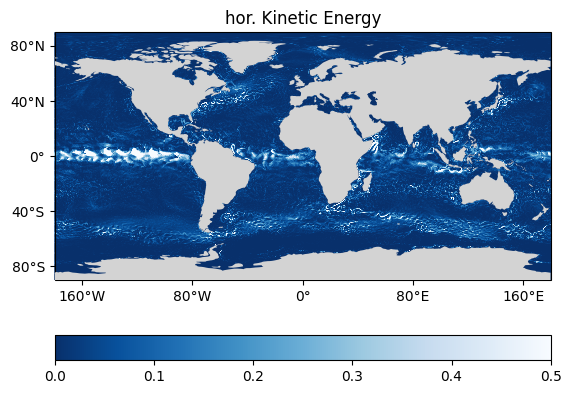

In [50]:
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from   cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
projection= ccrs.PlateCarree()

fig = plt.figure()
ax = plt.axes(projection=projection)
pc = ax.pcolormesh(arr_interp.lon, arr_interp.lat, arr_interp.data, vmin=0, vmax=0.5, cmap ='Blues_r', transform=projection)
ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=5)
plt.title('hor. Kinetic Energy')
fig.colorbar(pc, ax=ax, orientation='horizontal')

ax.set_xticks(np.arange(lon_reg[0], lon_reg[1], 4), crs=projection)
ax.set_yticks(np.arange(lat_reg[0], lat_reg[1], 4), crs=projection)
ax.xaxis.set_major_locator(plt.MaxNLocator(5)) # type: ignore
ax.yaxis.set_major_locator(plt.MaxNLocator(5)) # type: ignore
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)


show advantage of using precalcualted grid with dask for timeseries